In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

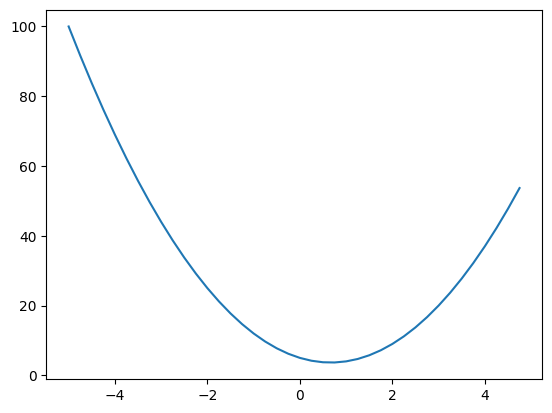

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [127]:
class Value():
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.
    self._backward = lambda:None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value({self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [7]:
a = Value(2., label='a')
b = Value(-3., label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'

In [8]:
d

Value(4.0)

In [9]:
d._prev

{Value(-6.0), Value(10)}

In [10]:
(a*b)._op

'*'

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

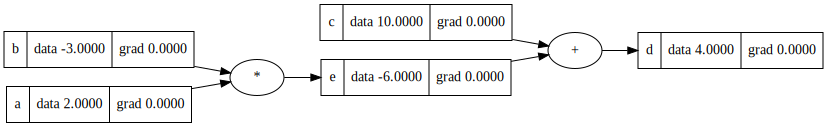

In [12]:
draw_dot(d)

In [13]:
a = Value(2., label='a')
b = Value(-3., label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
e.data
d = e + c; d.label='d'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'

L

Value(-8.0)

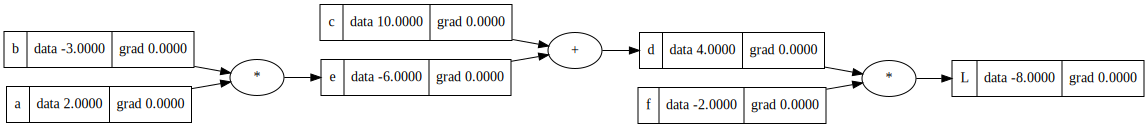

In [14]:
draw_dot(L)

In [15]:
def lol():

  h = 0.001
  a = Value(2., label='a')
  b = Value(-3., label='b')
  c = Value(10, label='c')
  e = a*b; e.label='e'
  d = e + c; d.label='d'
  f = Value(-2.0, label = 'f')
  L = d*f; L.label = 'L'
  L1 = L.data


  a = Value(2.+h, label='a')
  b = Value(-3., label='b')
  c = Value(10, label='c')
  e = a*b; e.label='e'
  e.data
  d = e + c; d.label='d'
  f = Value(-2.0, label = 'f')
  L = d*f; L.label = 'L'
  L2 = L.data
  print((L2-L1)/h)

lol()

6.000000000000227


In [16]:
L.grad = 1
d.grad = -2
f.grad = 4
e.grad = -2
c.grad = -2
a.grad = 6
b.grad = -4

In [17]:
a = Value(2., label='a')
b = Value(-3., label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
e.data
d = e + c; d.label='d'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'

print(f'Before Grad L:{L}')

# calculating grads
L.grad = 1
d.grad = -2
f.grad = 4
e.grad = -2
c.grad = -2
a.grad = 6
b.grad = -4

# updating grads
b.data += 0.1 * b.grad

# step
e = a*b
d = e+c
L = d*f
print(f'After Grad L:{L}')

Before Grad L:Value(-8.0)
After Grad L:Value(-6.4)


In [18]:
  b.data

-3.4

In [19]:
a = Value(2., label='a')
b = Value(-3., label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
e.data
d = e + c; d.label='d'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'

print(f'Before Grad L:{L}')

# calculating grads
L.grad = 1
d.grad = -2
f.grad = 4
e.grad = -2
c.grad = -2
a.grad = 6
b.grad = -4

# updating grads
a.data += 0.1 * a.grad

# step
e = a*b
d = e+c
L = d*f
print(f'After Grad L:{L}')

Before Grad L:Value(-8.0)
After Grad L:Value(-4.399999999999999)


In [20]:
a = Value(2., label='a')
b = Value(-3., label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
e.data
d = e + c; d.label='d'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'

print(f'Before Grad L:{L}')

# calculating grads
L.grad = 1
d.grad = -2
f.grad = 4
e.grad = -2
c.grad = -2
a.grad = 6
b.grad = -4

# updating grads
c.data += 0.1 * c.grad

# step
e = a*b
d = e+c
L = d*f
print(f'After Grad L:{L}')

Before Grad L:Value(-8.0)
After Grad L:Value(-7.600000000000001)


In [22]:
a = Value(2., label='a')
b = Value(-3., label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
e.data
d = e + c; d.label='d'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'

print(f'Before Grad L:{L}')

# calculating grads
L.grad = 1
d.grad = -2
f.grad = 4
e.grad = -2
c.grad = -2
a.grad = 6
b.grad = -4

# updating grads
a.data += 0.1 * a.grad

# step
e = a*b
d = e+c
L = d*f
print(f'After Grad L:{L}')

Before Grad L:Value(-8.0)
After Grad L:Value(-4.399999999999999)


In [24]:
-2* (2*(-3)+10)

-8

In [25]:
-2* (2.6*(-3)+10)

-4.399999999999999

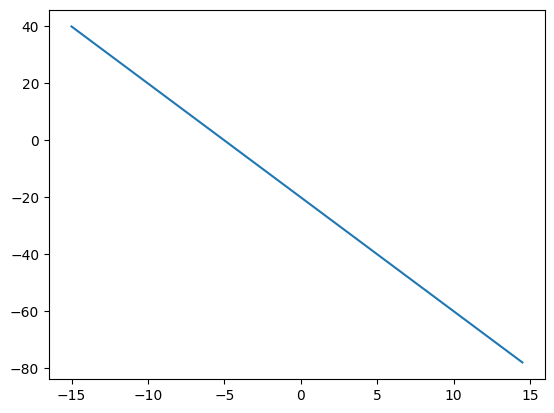

In [36]:
bees = np.arange(-15, 15, 0.5)
ells = []

for b in bees:
  L = -2 * (2*(b)+10)
  ells.append(L)

plt.plot(bees, ells)

In [72]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3., label='w1')
w2 = Value(1., label='w2')

b = Value(6.881373, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

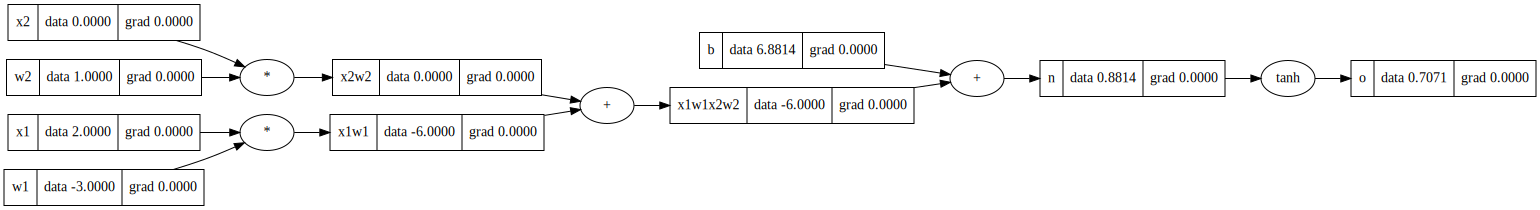

In [73]:
draw_dot(o)

In [74]:
# o.grad = 1.
# n.grad = 0.5
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x1.grad = -1.5
# w1.grad = 1.0
# x2.grad = 0.5
# w2.grad = 0

In [75]:
o.grad = 1.
o._backward()
n._backward()

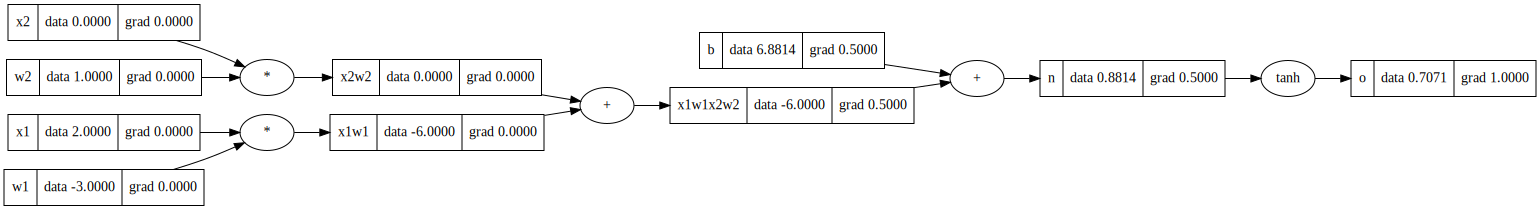

In [76]:
draw_dot(o)

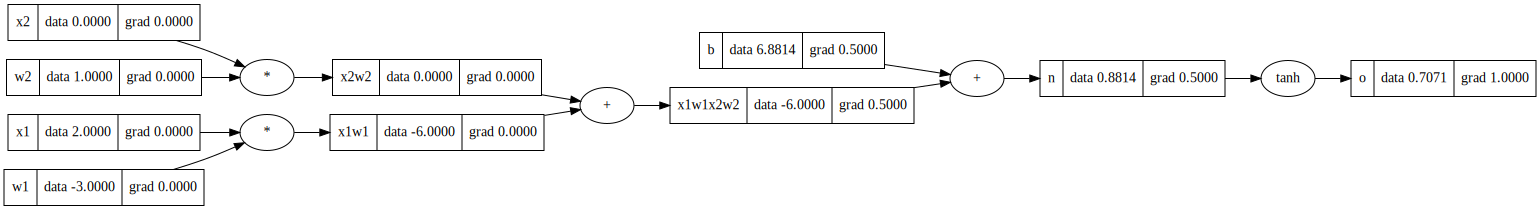

In [77]:
b._backward() # backward is nothing and lambda:None will be called
draw_dot(o)

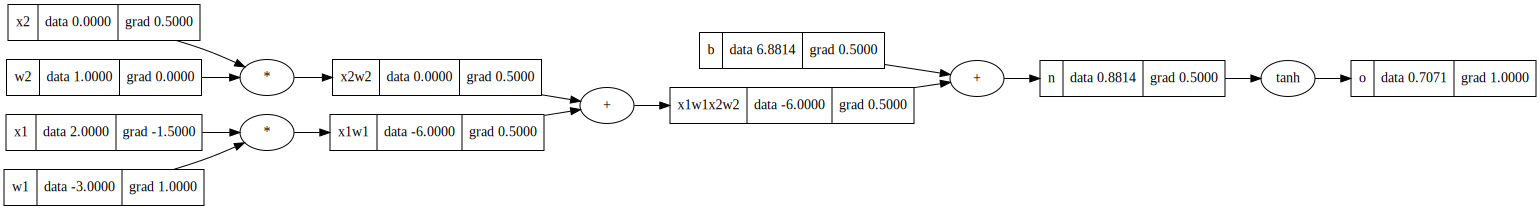

In [78]:
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

In [89]:
from numpy import random
import torch

In [90]:
# To do
# torch example

In [157]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
    # return outs #if we do this, each pred will be in a array.Uncomment n check

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [158]:
x = [2.0, 3.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(0.010033879292162344)

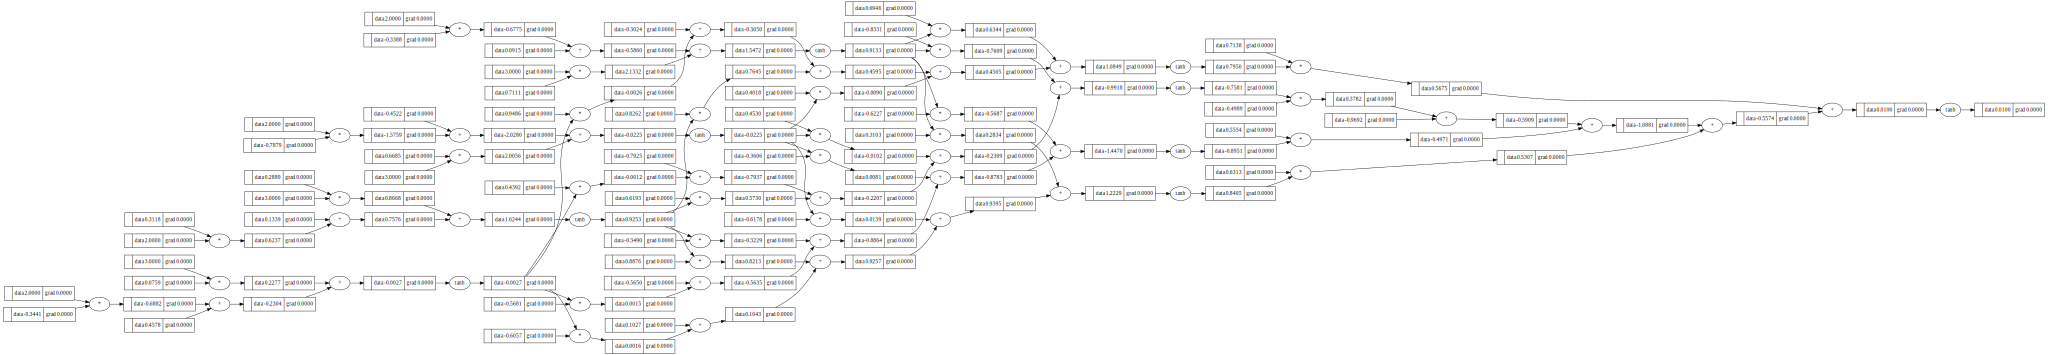

In [159]:
draw_dot(n(x))

In [160]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(0.009370016337159975),
 Value(-0.5802408769510143),
 Value(-0.32307004188054617),
 Value(-0.32162221833416754)]

In [161]:
for x in xs:
  print(x)
  break

[2.0, 3.0, -1.0]


In [162]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(3.3624649421088235)

In [196]:
loss.backward()

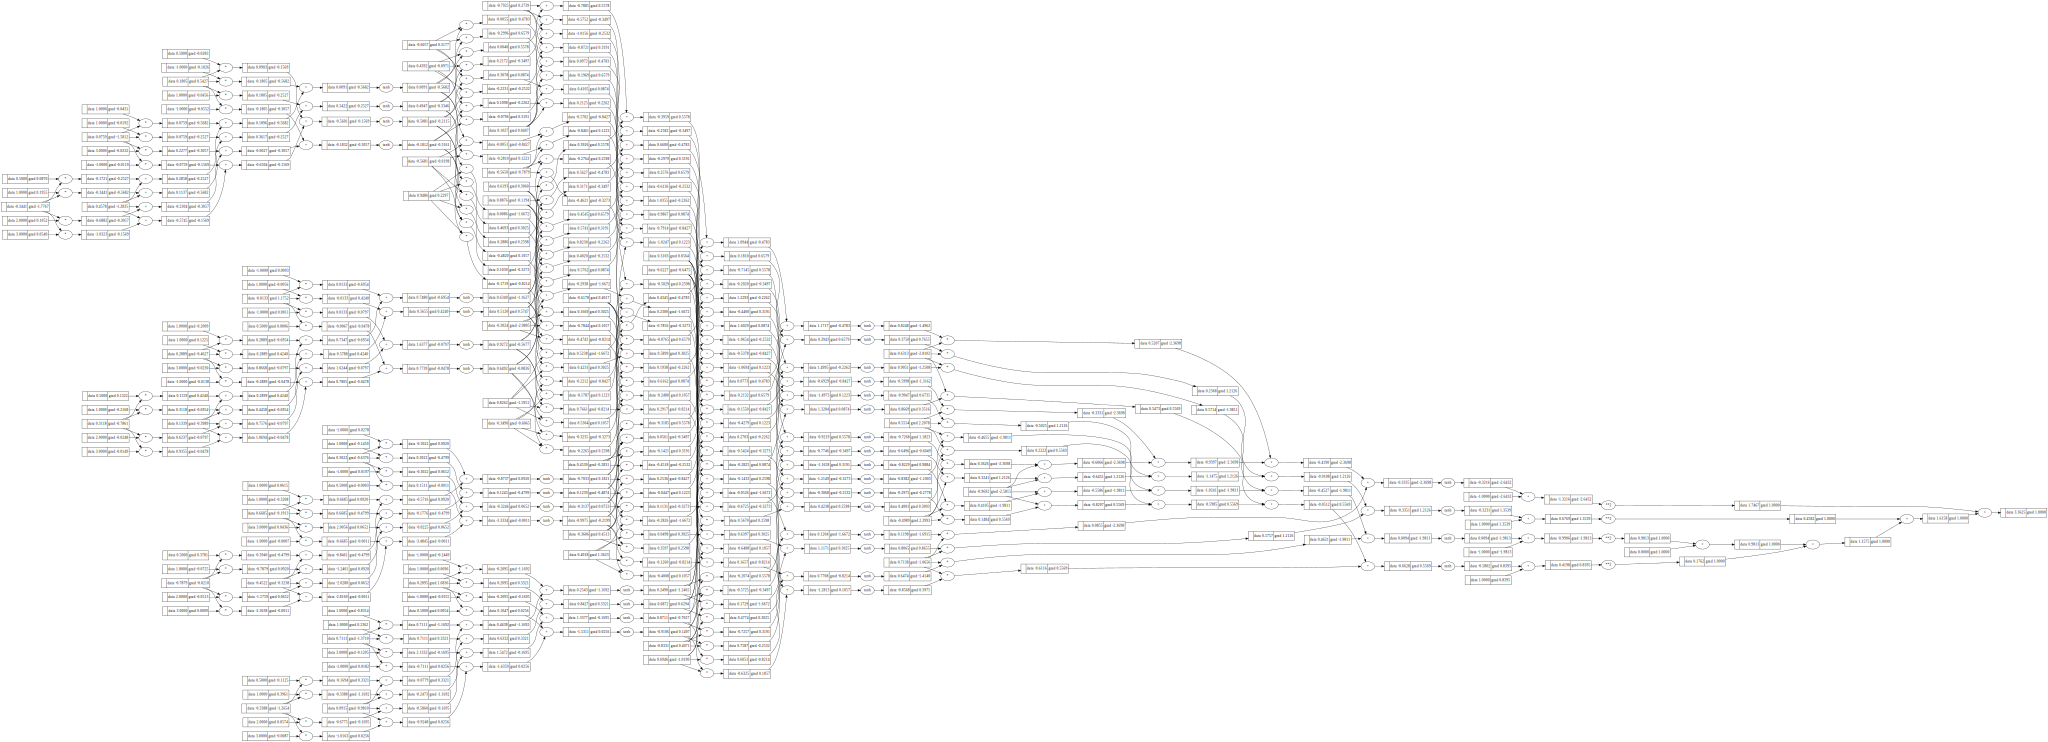

In [164]:
draw_dot(loss)

In [197]:
for p in n.parameters():
  p.data -= 0.03 * p.grad

In [198]:
n.layers[0].neurons[0].w[0]

Value(0.4049720982537238)

In [221]:
for k in range(10):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

  # backward pass
  for p in n.parameters():
    p.grad = 0.
  loss.backward()

  # update
  for p in n.parameters():
    p.data -= 0.03 * p.grad

  print(f'For epoch {k} Loss: {loss}')


For epoch 0 Loss: Value(6.55198199521323e-11)
For epoch 1 Loss: Value(6.551981993810441e-11)
For epoch 2 Loss: Value(6.55198199266145e-11)
For epoch 3 Loss: Value(6.551981991392467e-11)
For epoch 4 Loss: Value(6.551981990123484e-11)
For epoch 5 Loss: Value(6.551981988854501e-11)
For epoch 6 Loss: Value(6.551981987705508e-11)
For epoch 7 Loss: Value(6.551981986436525e-11)
For epoch 8 Loss: Value(6.551981985167542e-11)
For epoch 9 Loss: Value(6.55198198401855e-11)


In [223]:
ypred

[Value(0.9999945960692066),
 Value(-0.9999999478190564),
 Value(-0.9999999636851793),
 Value(0.999993973947378)]